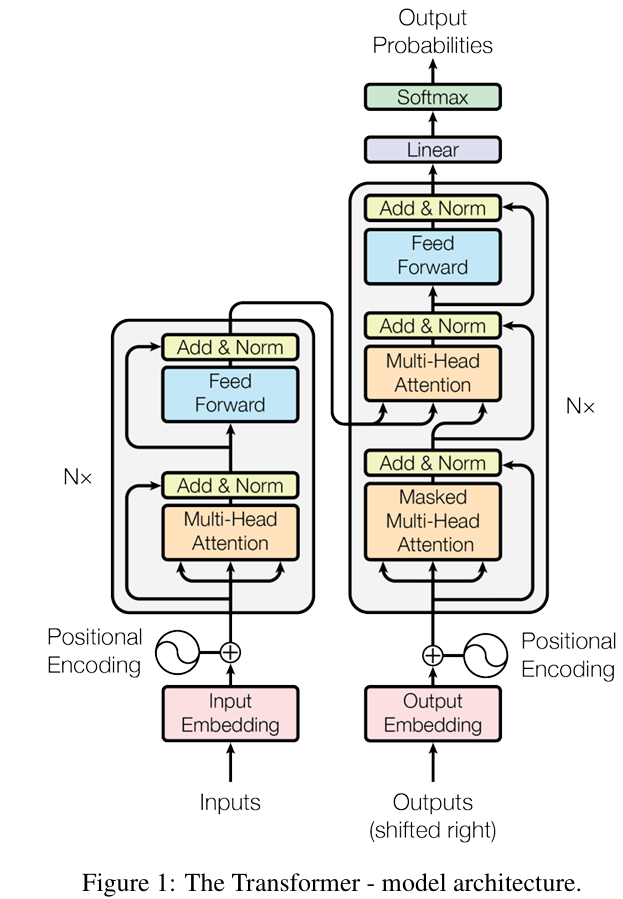

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 1. 简单字符级 Tokenizer
class SimpleTokenizer:
    def __init__(self, text):
        self.chars = sorted(set(text))  # 统计所有字符
        self.vocab_size = len(self.chars)
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}

    def encode(self, text):
        return [self.char_to_idx[ch] for ch in text]

    def decode(self, indices):
        return ''.join([self.idx_to_char[idx] for idx in indices])

# 示例数据
text = "hello world! this is a simple LLM."
tokenizer = SimpleTokenizer(text)

In [3]:
# 2. 定义 Transformer 解码器
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, dim_feedforward, max_len):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)  
        self.positional_encoding = nn.Parameter(torch.randn(1, max_len, d_model))  

        decoder_layer = nn.TransformerDecoderLayer(d_model, num_heads, dim_feedforward)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, input_seq, memory):
        # 嵌入层
        embedded = self.embedding(input_seq) + self.positional_encoding[:, :min(input_seq.size(1), self.positional_encoding.size(1)), :]
        memory = self.embedding(memory) + self.positional_encoding[:, :min(memory.size(1), self.positional_encoding.size(1)), :]

        # Transformer 解码器
        output = self.transformer_decoder(embedded, memory)
        return self.fc_out(output)

In [5]:
# 3. 创建模型实例
vocab_size = tokenizer.vocab_size
d_model = 32  
num_heads = 2  
num_layers = 2  
dim_feedforward = 64  
max_len = 100

model = TransformerDecoder(vocab_size, d_model, num_heads, num_layers, dim_feedforward, max_len)

# 4. 训练函数
def train(model, tokenizer, text, epochs=100, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    encoded_text = tokenizer.encode(text)
    input_tensor = torch.tensor([encoded_text[:-1]])  # 预测下一个字符
    target_tensor = torch.tensor([encoded_text[1:]])  

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(input_tensor, input_tensor)  
        loss = loss_fn(output.view(-1, vocab_size), target_tensor.view(-1))
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# 5. 训练模型
train(model, tokenizer, text)

Epoch 0, Loss: 2.9516468048095703
Epoch 10, Loss: 0.4547795057296753
Epoch 20, Loss: 0.061565376818180084
Epoch 30, Loss: 0.016055114567279816
Epoch 40, Loss: 0.0153195820748806
Epoch 50, Loss: 0.006505064200609922
Epoch 60, Loss: 0.005820757709443569
Epoch 70, Loss: 0.003471877658739686
Epoch 80, Loss: 0.0036848667077720165
Epoch 90, Loss: 0.0017726467922329903


In [6]:
# 6. 文本生成
def generate_text(model, tokenizer, start_text, max_length=50):
    model.eval()
    generated = tokenizer.encode(start_text)
    input_tensor = torch.tensor([generated])

    with torch.no_grad():
        for _ in range(max_length):
            output = model(input_tensor, input_tensor)
            next_token = output.argmax(dim=-1)[:, -1].item()
            generated.append(next_token)
            input_tensor = torch.tensor([generated])

    return tokenizer.decode(generated)

# 7. 测试文本生成
print("生成文本:", generate_text(model, tokenizer, "hi"))

生成文本: hillo world! this is a simple LLM.leldo  LLLMeleLwo 
